# Imports and settings

In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys

In [ ]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [4]:

env = gym.make('CartPole-v1')
seed = 0
env.reset(seed=seed)

(array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32),
 {})

In [5]:
from utils.classes import Policy

import utils.classes
torch.serialization.add_safe_globals([getattr, torch.nn.modules.linear.Linear, utils.classes.Policy])


# Testing baselines for REINFORCE

In [6]:
from utils.baselines import naive_baseline, baseline_1, baseline_2

from utils.reinforce import reinforce_rwd2go, reinforce_rwd2go_baseline

In [7]:
np.bool8 = bool
run=False

if run:
    # naive baseline
    policy_naive_baseline = Policy().to(device)
    optimizer_naive_baseline = optim.Adam(policy_naive_baseline.parameters(), lr=1e-2)
    scores_naive_baseline = reinforce_rwd2go_baseline(policy_naive_baseline, optimizer_naive_baseline, seed=seed, baseline=naive_baseline, env=env, early_stop=True, n_episodes=200)

    env = gym.make('CartPole-v0')


    # baseline 1
    policy_baseline_1 = Policy().to(device)
    optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
    scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, seed=seed, baseline=baseline_1, env=env, early_stop=True, n_episodes=200)

    env = gym.make('CartPole-v0')

    # baseline 2
    policy_baseline_2 = Policy().to(device)
    optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
    scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, seed=seed, baseline=baseline_2, env=env, early_stop=True, n_episodes=200)


In [8]:
if run:    
### Plot the learning progress

    # Create the plot
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    # Plot the scores with specified colors and labels
    #ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
    ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')
    ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')
    ax.plot(np.arange(1, len(scores_naive_baseline) + 1), scores_naive_baseline, color='black', label='Naive Baseline')

    # Set the labels with a larger font size
    ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
    ax.set_xlabel('Episode #', fontsize=20)

    # Set the tick labels to a larger font size
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Add a legend with a specified font size
    ax.legend(fontsize=20)

    # Show the plot
    plt.show()

# Generating the preference dataset

In [7]:
from utils.generate_preference_dataset import generate_trajectories


In [10]:
# Policy saving

np.bool8 = bool
seed = 0
env = gym.make('CartPole-v1')
env.reset(seed=seed)
target_score = 500
n_episodes = 500
print_every = 500
max_t = 1000
baseline = naive_baseline

example_policy = Policy().to(device)
optimizer_baseline_1 = optim.Adam(example_policy.parameters(), lr=1e-2)
example_scores = reinforce_rwd2go_baseline(example_policy, optimizer_baseline_1, seed=seed, env=env, target_score=target_score, baseline=baseline, early_stop=False, n_episodes=n_episodes, max_t=max_t, print_every=print_every, save_models_every=False)

Episode 0	Average Score: 59.00
Episode 0	Current Score: 59.00
Episode 0	Current Score: 59.00
Episode 3	Current Score: 63.00
Episode 13	Current Score: 90.00
Episode 21	Current Score: 129.00
Episode 28	Current Score: 148.00
Episode 31	Current Score: 151.00
Episode 45	Current Score: 196.00
Episode 56	Current Score: 237.00
Episode 74	Current Score: 268.00
Episode 76	Current Score: 467.00
Episode 76	Current Score: 467.00
Episode 99	Current Score: 521.00
Episode 99	Current Score: 521.00
Episode 100	Current Score: 901.00
Episode 104	Current Score: 1000.00
Episode 105	Current Score: 1000.00
Episode 106	Current Score: 1000.00
Episode 108	Current Score: 1000.00
Episode 109	Current Score: 1000.00
Episode 110	Current Score: 1000.00
Episode 111	Current Score: 1000.00
Episode 112	Current Score: 1000.00
Episode 114	Current Score: 521.00
Episode 336	Current Score: 461.00
Episode 337	Current Score: 541.00
Episode 339	Current Score: 1000.00
Episode 340	Current Score: 1000.00
Episode 341	Current Score: 1

# Loading policies (manual intervention required)

Rename the policies you want to choose as $\pi_1$ and $\pi_2$

In [11]:
PATH = os.path.abspath(os.getcwd())

# TO COMPLETE, choose the file names of the desired policies

pi1_path = os.path.join(PATH, 'saved_policies', 'pi1_cartpole_0.pt')

pi2_path = os.path.join(PATH, 'saved_policies', 'pi2_cartpole_0.pt')

In [22]:
# Compare on K trajectories

seeds = [0,1,2]
n_trajectories = 500
max_t=1000
rewards_for_all_seeds_pi1 = np.zeros((n_trajectories, len(seeds)))
rewards_for_all_seeds_pi2 = np.zeros((n_trajectories, len(seeds)))

for seed_index, seed in enumerate(seeds):
    pi1 = Policy().to(device)
    pi1.load_state_dict(torch.load(pi1_path, weights_only=True))

    env = gym.make('CartPole-v1')
    trajectories_rewards_pi1, trajectories_states_pi1, trajectories_actions_pi1 = generate_trajectories(pi1, n_trajectories, env=env, max_t=max_t, seed = seed, dim_state=4)

    rewards_for_all_seeds_pi1[:,seed_index] = trajectories_rewards_pi1[:]

    pi2 = Policy().to(device)
    pi2.load_state_dict(torch.load(pi2_path, weights_only=True))

    env = gym.make('CartPole-v1')
    trajectories_rewards_pi2, trajectories_states_pi2, trajectories_actions_pi2 = generate_trajectories(pi2, n_trajectories, env=env, max_t=max_t, seed = seed, dim_state=4)

    rewards_for_all_seeds_pi2[:,seed_index] = trajectories_rewards_pi2[:]

rewards_avg_seeds_pi1 = np.mean(rewards_for_all_seeds_pi1, axis=1)
rewards_avg_seeds_pi2 = np.mean(rewards_for_all_seeds_pi2, axis=1)



Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Trajectory:  100
Trajectory:  110
Trajectory:  120
Trajectory:  130
Trajectory:  140
Trajectory:  150
Trajectory:  160
Trajectory:  170
Trajectory:  180
Trajectory:  190
Trajectory:  200
Trajectory:  210
Trajectory:  220
Trajectory:  230
Trajectory:  240
Trajectory:  250
Trajectory:  260
Trajectory:  270
Trajectory:  280
Trajectory:  290
Trajectory:  300
Trajectory:  310
Trajectory:  320
Trajectory:  330
Trajectory:  340
Trajectory:  350
Trajectory:  360
Trajectory:  370
Trajectory:  380
Trajectory:  390
Trajectory:  400
Trajectory:  410
Trajectory:  420
Trajectory:  430
Trajectory:  440
Trajectory:  450
Trajectory:  460
Trajectory:  470
Trajectory:  480
Trajectory:  490
Trajectory:  0
Trajectory:  10
Trajectory:  20
Trajectory:  30
Trajectory:  40
Trajectory:  50
Trajectory:  60
Trajectory:  70
Trajectory:  80
Trajectory:  90
Tr

## Making sure $\pi_1$ performs $\sim$ twice as good as $\pi_2$:

In [23]:
avg_pi1 = np.mean(rewards_avg_seeds_pi1)
avg_pi2 = np.mean(rewards_avg_seeds_pi2)
print(avg_pi1, avg_pi2)

851.7273333333334 401.01733333333334


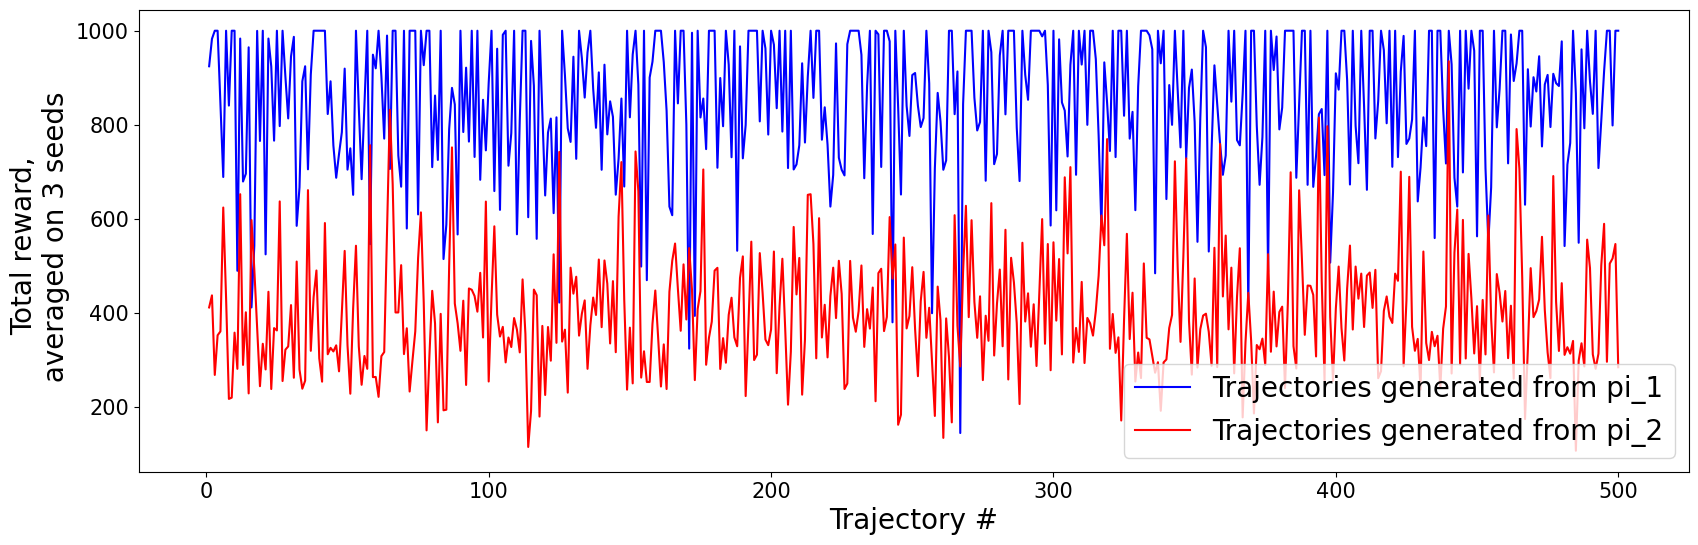

In [24]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
#ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')
ax.plot(np.arange(1, n_trajectories + 1), rewards_avg_seeds_pi1, color='blue', label='Trajectories generated from pi_1')
ax.plot(np.arange(1, n_trajectories + 1), rewards_avg_seeds_pi2, color='red', label='Trajectories generated from pi_2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward, \n averaged on 3 seeds', fontsize=20)
ax.set_xlabel('Trajectory #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()